# Загрузка Pandas и очистка данных

In [61]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as req
from datetime import datetime, timedelta
%matplotlib inline

In [2]:
# pip install bs4
from bs4 import BeautifulSoup

Исходный датасет сохраним в переменную df_raw

In [3]:
df_raw = pd.read_csv('main_task.csv')

In [4]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 200)  # показывать больше колонок

Посмотрим на наш датасет:

In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [6]:
df_raw.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


Работать будем с переменной df_prepare, удалим колонки, которые для модели бесполезны:

In [7]:
df_prepare = df_raw
df_prepare = df_prepare.drop(['Restaurant_id', 'URL_TA', 'ID_TA'], axis=1)

Вначале разберемся с колонкой City. Она, как мы видим, без пропусков.

In [8]:
df_prepare.City.nunique()

31

In [9]:
df_prepare.City.value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

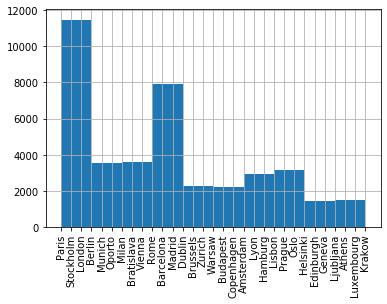

In [10]:
df_prepare.City.hist(xrot=90)

Судя по графику и по сумме значений для каждого города, все города значимы, убирать, заменять их не будем. Так как признак категориальный, то переведем его в Dummy переменные. Чтобы не загромождать исходный датасет, все, что связано с городами, будем хранить в отдельном датасете City_dummies.

In [11]:
City_dummies = pd.get_dummies(df_prepare.City)
Cities_columns = City_dummies.columns
City_dummies = pd.concat([df_prepare['City'], City_dummies], axis=1)

На основе данных о городах создадим новые признаки:

In [12]:
Cities_columns

Index(['Amsterdam', 'Athens', 'Barcelona', 'Berlin', 'Bratislava', 'Brussels',
       'Budapest', 'Copenhagen', 'Dublin', 'Edinburgh', 'Geneva', 'Hamburg',
       'Helsinki', 'Krakow', 'Lisbon', 'Ljubljana', 'London', 'Luxembourg',
       'Lyon', 'Madrid', 'Milan', 'Munich', 'Oporto', 'Oslo', 'Paris',
       'Prague', 'Rome', 'Stockholm', 'Vienna', 'Warsaw', 'Zurich'],
      dtype='object')

In [13]:
# Является ли город столицей
Capitals = {'Amsterdam': 1, 'Athens': 1, 'Barcelona': 0, 'Berlin': 1, 'Bratislava': 1, 'Brussels': 1,
            'Budapest': 1, 'Copenhagen': 1, 'Dublin': 1, 'Edinburgh': 1, 'Geneva': 0, 'Hamburg': 0,
            'Helsinki': 1, 'Krakow': 0, 'Lisbon': 1, 'Ljubljana': 1, 'London': 1, 'Luxembourg': 1,
            'Lyon': 0, 'Madrid': 1, 'Milan': 0, 'Munich': 0, 'Oporto': 0, 'Oslo': 1, 'Paris': 1,
            'Prague': 1, 'Rome': 1, 'Stockholm': 1, 'Vienna': 1, 'Warsaw': 1, 'Zurich': 0}
City_dummies['Capital'] = City_dummies['City'].map(Capitals)

Воспользуемся данными сайта https://www.numbeo.com/, напишем различные рейтинги городов.

In [98]:
resp = req.get(
    "https://www.numbeo.com/cost-of-living/region_rankings_current.jsp?region=150")
soup = BeautifulSoup(resp.text, 'lxml')

In [15]:
tab = soup.find("table", id="t2")
cost_living = {}  # стоимость жизни
rent_ind = {}  # индекс аренды
gros_ind = {}  # индекс цен на продовольственные товары
rest_price_ind = {}  # индекс цен в ресторанах
purch_ind = {}  # индекс покупательской способности
for tr in tab.find_all('tr')[1:]:
    tds = tr.find_all('td')
    city = tds[1].text[0:tds[1].text.find(',')]
    if city.find('(') > 0:
        city = city[0: city.find(' ')]
    city = city.replace('Porto', 'Oporto')

    if city in Cities_columns:
        cost_living[city] = float(tds[2].text)
        rent_ind[city] = float(tds[3].text)
        gros_ind[city] = float(tds[5].text)
        rest_price_ind[city] = float(tds[6].text)
        purch_ind[city] = float(tds[7].text)
City_dummies['living_ind'] = City_dummies['City'].map(cost_living)
City_dummies['rent_ind'] = City_dummies['City'].map(rent_ind)
City_dummies['gros_ind'] = City_dummies['City'].map(gros_ind)
City_dummies['rest_ind'] = City_dummies['City'].map(rest_price_ind)
City_dummies['purch_ind'] = City_dummies['City'].map(purch_ind)

In [16]:
resp = req.get(
    "https://www.numbeo.com/quality-of-life/region_rankings_current.jsp?region=150")
soup = BeautifulSoup(resp.text, 'lxml')

In [17]:
tab = soup.find("table", id="t2")
quality_ind = {}  # индекс качества жизни
safety_ind = {}  # индекс безопасности
healf_ind = {}  # индекс здоровья
property_ratio = {}  # индекc отношения уровня жизни к стоимости недвижимости
traffic_ind = {}  # индекс транспортной загруженности
pollution_ind = {}  # индекс загрязненности
climate_ind = {}  # индекс климата
cnt = 0
for tr in tab.find_all('tr')[1:]:
    tds = tr.find_all('td')
    city = tds[1].text[0:tds[1].text.find(',')]
    if city.find('(') > 0:
        city = city[0: city.find(' ')]
    city = city.replace('Porto', 'Oporto')

    if city in Cities_columns:
        quality_ind[city] = float(tds[2].text)
        safety_ind[city] = float(tds[4].text)
        healf_ind[city] = float(tds[5].text)
        property_ratio[city] = float(tds[7].text)
        traffic_ind[city] = float(tds[8].text)
        pollution_ind[city] = float(tds[9].text)
        climate_ind[city] = float(tds[10].text)
City_dummies['quality_ind'] = City_dummies['City'].map(quality_ind)
City_dummies['safety_ind'] = City_dummies['City'].map(safety_ind)
City_dummies['healf_ind'] = City_dummies['City'].map(healf_ind)
City_dummies['property_ratio'] = City_dummies['City'].map(property_ratio)
City_dummies['traffic_ind'] = City_dummies['City'].map(traffic_ind)
City_dummies['pollution_ind'] = City_dummies['City'].map(pollution_ind)
City_dummies['climate_ind'] = City_dummies['City'].map(climate_ind)

In [18]:
# Туристический рейтинг городов в 2019 г.(по даным euromonitor.com)
turism = {'Amsterdam': 25, 'Athens': 43, 'Barcelona': 33, 'Berlin': 41, 'Bratislava': 101, 'Brussels': 60,
          'Budapest': 62, 'Copenhagen': 71, 'Dublin': 50, 'Edinburgh': 101, 'Geneva': 101, 'Hamburg': 101,
          'Helsinki': 101, 'Krakow': 74, 'Lisbon': 63, 'Ljubljana': 101, 'London': 3, 'Luxembourg': 101,
          'Lyon': 101, 'Madrid': 47, 'Milan': 35, 'Munich': 56, 'Oporto': 96, 'Oslo': 101, 'Paris': 6,
          'Prague': 22, 'Rome': 16, 'Stockholm': 88, 'Vienna': 37, 'Warsaw': 83, 'Zurich': 101}
City_dummies['turism_ind'] = City_dummies['City'].map(turism)

In [19]:
# Население города (млн.), данные из интернета
population = {'Amsterdam': 0.86, 'Athens': 0.66, 'Barcelona': 1.6, 'Berlin': 3.6, 'Bratislava': 0.4, 'Brussels': 0.19,
              'Budapest': 1.75, 'Copenhagen': 0.79, 'Dublin': 1.17, 'Edinburgh': 0.52, 'Geneva': 0.2, 'Hamburg': 1.84,
              'Helsinki': 0.64, 'Krakow': 0.78, 'Lisbon': 0.51, 'Ljubljana': 0.28, 'London': 8.91, 'Luxembourg': 0.12,
              'Lyon': 0.52, 'Madrid': 3.23, 'Milan': 1.34, 'Munich': 1.47, 'Oporto': 0.24, 'Oslo': 0.69, 'Paris': 2.15,
              'Prague': 1.32, 'Rome': 2.87, 'Stockholm': 0.98, 'Vienna': 1.9, 'Warsaw': 1.79, 'Zurich': 0.43}
City_dummies['population'] = City_dummies['City'].map(population)

In [20]:
# Площадь города (кв км), данные из интернета
area = {'Amsterdam': 219, 'Athens': 412, 'Barcelona': 101, 'Berlin': 891, 'Bratislava': 368, 'Brussels': 32.6,
        'Budapest': 525, 'Copenhagen': 86.4, 'Dublin': 115, 'Edinburgh': 175, 'Geneva': 15.9, 'Hamburg': 755,
        'Helsinki': 715, 'Krakow': 327, 'Lisbon': 100, 'Ljubljana': 163, 'London': 1706, 'Luxembourg': 51.5,
        'Lyon': 47.9, 'Madrid': 607, 'Milan': 181, 'Munich': 310, 'Oporto': 41.7, 'Oslo': 454, 'Paris': 105,
        'Prague': 496, 'Rome': 1287, 'Stockholm': 188, 'Vienna': 414, 'Warsaw': 517, 'Zurich': 91.9}
City_dummies['area'] = City_dummies['City'].map(area)

In [21]:
# Добавим еще признак плотность населения на основе двух предыдущих
City_dummies['density'] = City_dummies['population']*1000/City_dummies['area']

In [22]:
City_dummies

,City,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Capital,living_ind,rent_ind,gros_ind,rest_ind,purch_ind,quality_ind,safety_ind,healf_ind,property_ratio,traffic_ind,pollution_ind,climate_ind,turism_ind,population,area,density
0,Paris,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,92.10,48.92,91.03,83.73,71.40,118.78,47.50,79.41,21.51,41.28,65.10,88.39,6,2.15,105.0,20.476190
1,Stockholm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,84.28,40.86,74.32,85.63,83.02,156.65,54.83,66.87,14.39,36.09,19.63,69.67,88,0.98,188.0,5.212766
2,London,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,83.76,69.43,62.45,85.88,83.32,129.60,47.35,71.26,15.77,43.81,58.91,88.25,3,8.91,1706.0,5.222743
3,Berlin,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,70.43,34.21,58.22,57.14,94.81,163.47,59.17,69.81,9.60,33.66,39.41,83.35,41,3.60,891.0,4.040404
4,Munich,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,80.44,46.79,65.69,76.20,90.20,176.04,82.33,78.36,16.76,33.06,24.81,75.98,56,1.47,310.0,4.741935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Milan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,82.03,44.42,71.04,81.46,53.40,118.49,56.73,72.09,18.07,36.74,67.19,88.12,35,1.34,181.0,7.403315
39996,Paris,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,92.10,48.92,91.03,83.73,71.40,118.78,47.50,79.41,21.51,41.28,65.10,88.39,6,2.15,105.0,20.476190
39997,Stockholm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,84.28,40.86,74.32,85.63,83.02,156.65,54.83,66.87,14.39,36.09,19.63,69.67,88,0.98,188.0,5.212766
39998,Warsaw,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,45.99,24.89,36.86,39.66,52.77,131.45,74.50,61.84,15.19,35.08,58.79,74.61,83,1.79,517.0,3.462282


Построим графики зависимостей рейтинга от новых признаков:

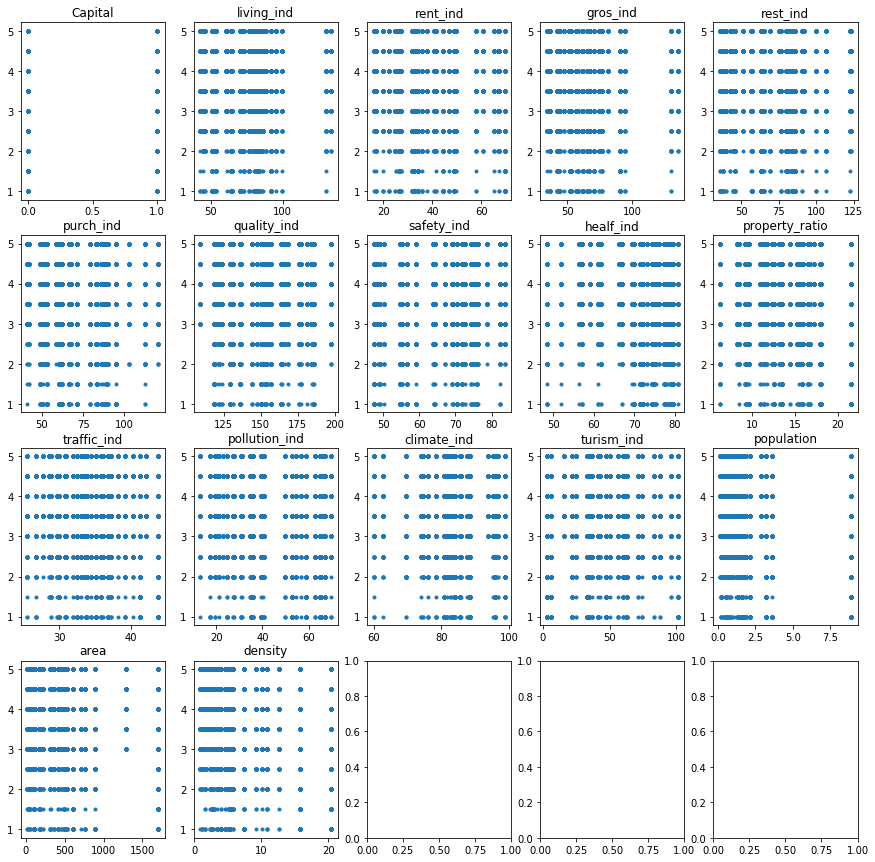

In [23]:
fig, pl = plt.subplots(4, 5, figsize=(15, 15))

for ind, col in enumerate(City_dummies.columns[32:], 0):
    pl_row, pl_col = divmod(ind, 5)
    pl[pl_row, pl_col].scatter(
        x=City_dummies[col], y=df_prepare['Rating'], marker='.')
    pl[pl_row, pl_col].set_title(col)

Графики показывают, что полдня работы коту под хвост( Зато научилась парсить сайты.

Посмотрим, что показывают графики распределения оценок внутри каждого города

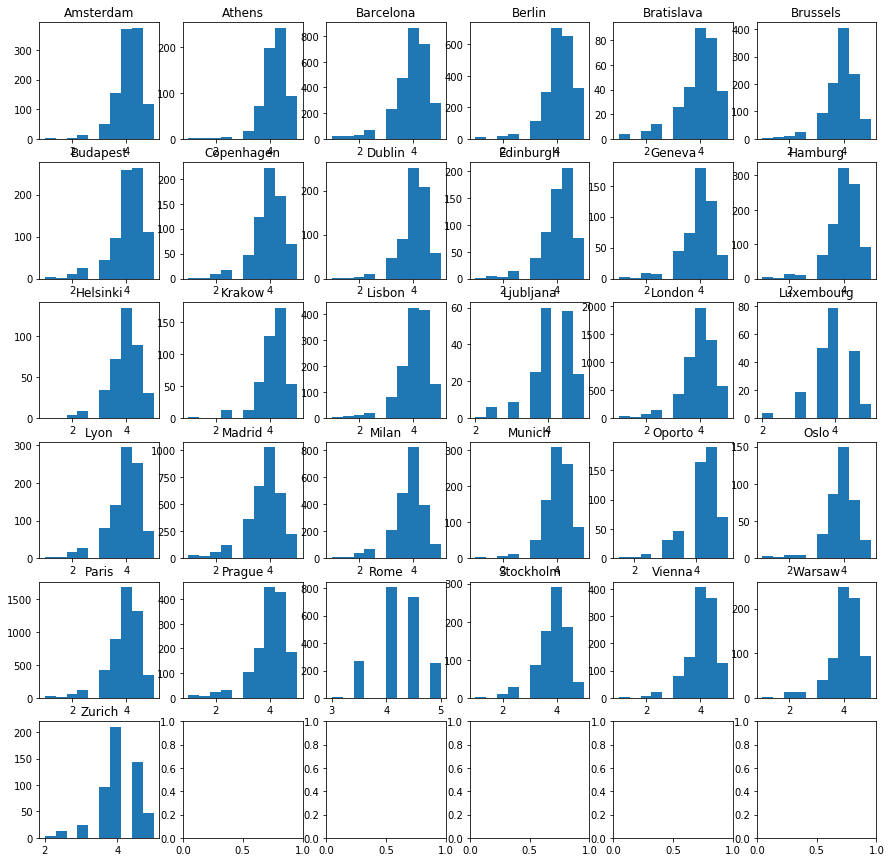

In [25]:
fig, pl = plt.subplots(6, 6, figsize=(15, 15))

for ind, col in enumerate(City_dummies.columns[1:32], 0):
    pl_row, pl_col = divmod(ind, 6)
    pl[pl_row, pl_col].hist(df_prepare.Rating[df_prepare.City == col])
    pl[pl_row, pl_col].set_title(col)

Графики очень похожи, наверно поэтому не было смысла искать дополнительные признаки у городов.

Перейдем к колонке "Тип кухни". В ней есть пропуски. Пока не будем их трогать, посмотрим сколько типов кухонь представлено в датасете:

In [26]:
Cuisine_ser = df_prepare[~df_prepare['Cuisine Style'].isna()]['Cuisine Style']
Cuisine_ser = Cuisine_ser.astype('str').apply(lambda x: eval(x))
Cuisine_ser = Cuisine_ser.explode()
Cuisine_cnts = Cuisine_ser.value_counts()

In [27]:
print(list(Cuisine_cnts))
print(len(Cuisine_cnts))

[11189, 10060, 6277, 5964, 4486, 4113, 3297, 3190, 3011, 2849, 2798, 2449, 2325, 1705, 1595, 1584, 1505, 1464, 1393, 1315, 1156, 1145, 1107, 1041, 782, 743, 697, 662, 620, 604, 598, 595, 577, 573, 555, 523, 513, 496, 494, 490, 471, 445, 444, 392, 380, 372, 365, 352, 342, 329, 302, 295, 294, 284, 270, 263, 225, 178, 177, 171, 169, 167, 163, 154, 141, 135, 127, 123, 94, 93, 83, 83, 76, 75, 74, 68, 59, 58, 53, 51, 48, 42, 40, 31, 27, 25, 25, 24, 24, 23, 22, 22, 21, 21, 20, 20, 20, 20, 19, 18, 17, 17, 14, 14, 12, 12, 11, 10, 8, 8, 6, 5, 5, 4, 4, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1]
125


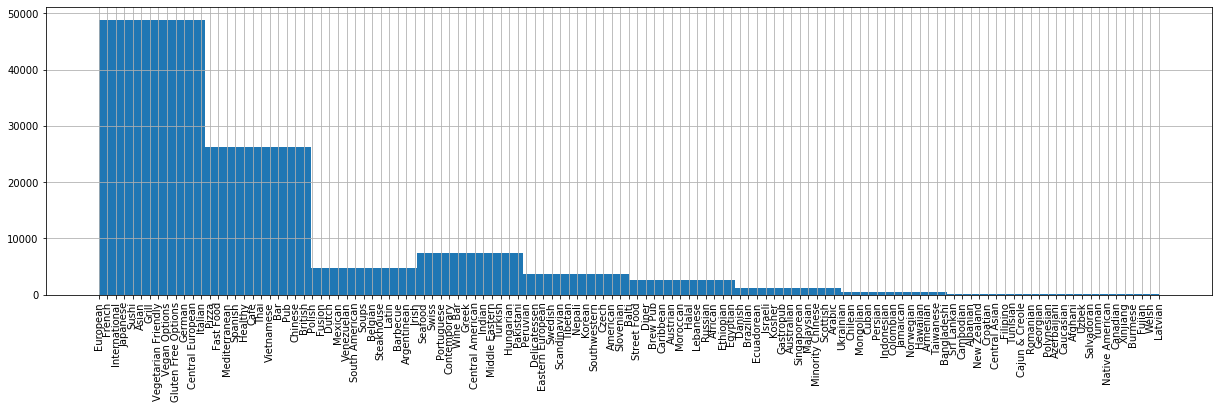

In [28]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2.7, 1])
Cuisine_ser.hist(xrot=90)

По списку значений и графику мы видим, что большинство кухонь представлены в датасете в очень малом количестве. Оставим только топовые кухни, остальные переименуем в тип "others". Число отсечения будем задавать, сделаем возможность менять это число и эксперементировать с ним.

In [29]:
Cuisine_limit = 400  # 10% от количества данных в датасете
Cuisine_columns = list(Cuisine_cnts[Cuisine_cnts > Cuisine_limit].index)
Other_columns = list(set(Cuisine_cnts.index) - set(Cuisine_columns))

In [30]:
print(Cuisine_columns)
print(Other_columns)

['Vegetarian Friendly', 'European', 'Mediterranean', 'Italian', 'Vegan Options', 'Gluten Free Options', 'Bar', 'French', 'Asian', 'Pizza', 'Spanish', 'Pub', 'Cafe', 'Fast Food', 'British', 'International', 'Seafood', 'Japanese', 'Central European', 'American', 'Sushi', 'Chinese', 'Portuguese', 'Indian', 'Middle Eastern', 'Thai', 'Wine Bar', 'German', 'Healthy', 'Greek', 'Halal', 'Czech', 'Fusion', 'Steakhouse', 'Barbecue', 'Contemporary', 'Vietnamese', 'Eastern European', 'Soups', 'Grill', 'Gastropub', 'Mexican', 'Turkish']
['Xinjiang', 'Tibetan', 'Polynesian', 'Swiss', 'Salvadoran', 'Latin', 'Hungarian', 'Burmese', 'Native American', 'Moroccan', 'Danish', 'Pakistani', 'Malaysian', 'Chilean', 'Slovenian', 'Kosher', 'Delicatessen', 'Caribbean', 'Taiwanese', 'Central Asian', 'Irish', 'Peruvian', 'Russian', 'Singaporean', 'Austrian', 'Canadian', 'Uzbek', 'Cajun & Creole', 'Filipino', 'Dutch', 'Arabic', 'Croatian', 'Persian', 'Australian', 'Fujian', 'African', 'Nepali', 'New Zealand', 'Leb

По аналогии с городами создадим отдельный датасет с кухнями, пропуски заменим типом кухни "Европейская":

In [31]:
df_prepare['Cuisine Style'] = df_prepare['Cuisine Style'].fillna(
    "['European']")
Cuisine_dummies = pd.DataFrame(df_prepare['Cuisine Style'])

for Cuisine in Cuisine_columns:
    Cuisine_dummies[Cuisine] = Cuisine_dummies['Cuisine Style'].astype(
        'str').apply(lambda x: 1 if Cuisine in x else 0)


def other_cuisine(cuisine_str):
    for Cuisine in Other_columns:
        if Cuisine in cuisine_str:
            return 1
    return 0


Cuisine_dummies['Other cuisine'] = Cuisine_dummies['Cuisine Style'].astype(
    'str').apply(other_cuisine)

In [32]:
Cuisine_dummies.head()

,Cuisine Style,Vegetarian Friendly,European,Mediterranean,Italian,Vegan Options,Gluten Free Options,Bar,French,Asian,Pizza,Spanish,Pub,Cafe,Fast Food,British,International,Seafood,Japanese,Central European,American,Sushi,Chinese,Portuguese,Indian,Middle Eastern,Thai,Wine Bar,German,Healthy,Greek,Halal,Czech,Fusion,Steakhouse,Barbecue,Contemporary,Vietnamese,Eastern European,Soups,Grill,Gastropub,Mexican,Turkish,Other cuisine
0,"['European', 'French', 'International']",0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,['European'],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,['European'],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"['German', 'Central European', 'Vegetarian Fri...",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Построим графики распределения оценок внутри каждой кухни.

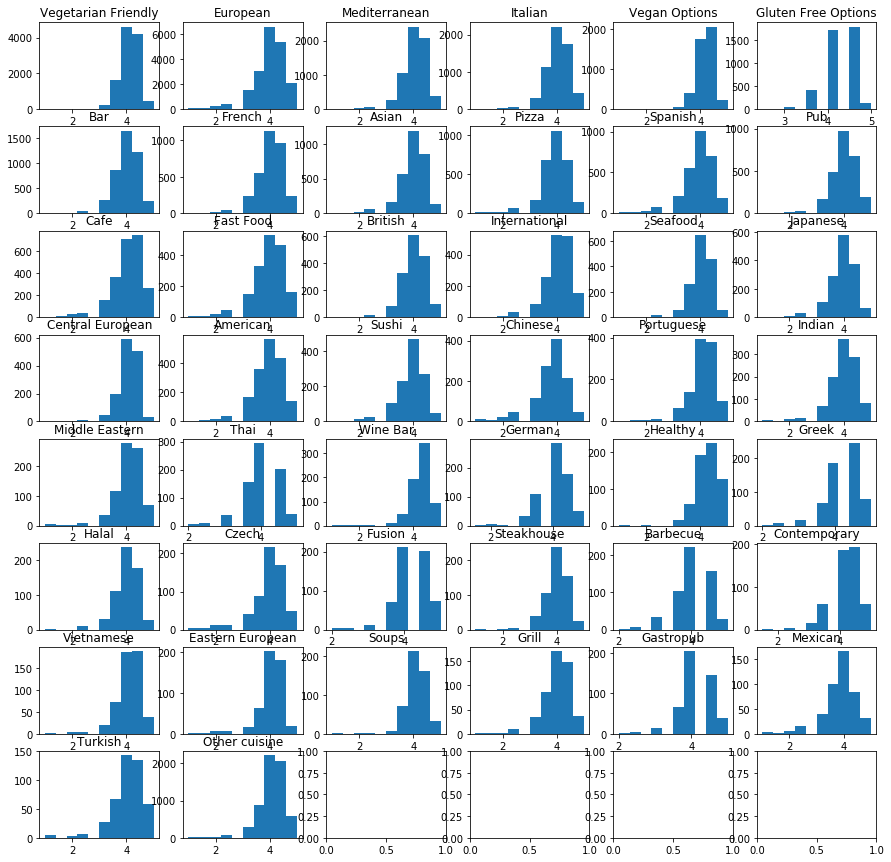

In [43]:
df_temp = pd.concat([df_prepare['Rating'], Cuisine_dummies], axis=1)
fig, pl = plt.subplots(8, 6, figsize=(15, 15))

for ind, col in enumerate(df_temp.columns[2:], start=0):
    pl_row, pl_col = divmod(ind, 6)
    pl[pl_row, pl_col].hist(df_temp.Rating[df_temp[col] == 1])
    pl[pl_row, pl_col].set_title(col)
del df_temp

Как в примере с городами, распредление оценок примерно одинаковое, создавать новые признаки на основе типов кухонь не будем.

Колонка Ranking. 

In [116]:
df_prepare['Ranking'].describe()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: Ranking, dtype: float64

Эта колонка содержит большие значения. Создадим признак: корень из этого значения:

In [117]:
df_prepare['Ranking_sqrt'] = df_prepare['Ranking'].apply(lambda x: x**0.5)

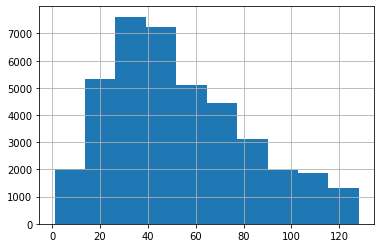

In [118]:
df_prepare['Ranking_sqrt'].hist()

Распределение нормальное. Колонка Rating. Проверим, что она содержит только допустимые значения:

In [40]:
df_prepare['Rating'].unique()

array([3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

Недопустимых значений нет. Проверим колонку Price Range:

In [44]:
df_prepare['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

Во-первых, колонка содержит некоторые обозначения, которые не понятны алгоритму, переведем их в числовые обозначения. Во-вторых, есть пропуски, которые мы заменим значением "Средний чек".

In [45]:
df_prepare['Price Range'] = df_prepare['Price Range'].fillna('$$ - $$$')

price_dict = {'$': 1, '$$ - $$$': 2, '$$$$': 3}
df_prepare['Price Range'] = df_prepare['Price Range'].map(price_dict)

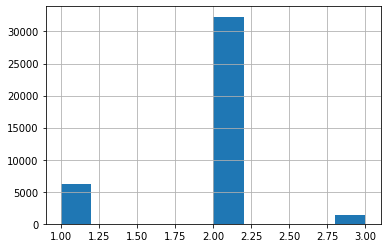

In [167]:
df_prepare['Price Range'].hist()

Проверим вначале колонку "Number of Reviews". Посмотрим на колонки с пропусками.

In [46]:
df_prepare[df_prepare['Number of Reviews'].isna()]

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews
8,Vienna,['European'],2692.0,4.0,2,NaN,"[[], []]"
21,Madrid,['European'],5847.0,4.0,2,NaN,"[[], []]"
32,Budapest,['European'],1328.0,5.0,2,NaN,"[['Absolutely amazing, tasty, fresh, cheap Ch...."
102,Budapest,"['French', 'European', 'Hungarian']",1410.0,5.0,2,NaN,"[[], []]"
108,Prague,"['Italian', 'Mediterranean']",2050.0,5.0,2,NaN,"[[], []]"
...,...,...,...,...,...,...,...
39965,Rome,['European'],5722.0,5.0,2,NaN,"[[], []]"
39972,Prague,"['Cafe', 'Delicatessen', 'Healthy', 'Wine Bar'...",2012.0,5.0,1,NaN,"[['Personal expirence'], ['10/27/2017']]"
39986,Madrid,['European'],7279.0,3.0,2,NaN,"[[], []]"
39988,Berlin,['European'],4970.0,4.0,2,NaN,"[[], []]"


Пропуски там, где либо 0 значений, либо 1. Заменим пропуски значениями либо 0 либо 1:

In [47]:
df_slice = df_prepare[df_prepare['Number of Reviews'].isna()]
df_prepare = df_prepare.dropna(subset=['Number of Reviews'], axis=0)
df_slice['Number of Reviews'] = df_slice['Reviews'].apply(
    lambda x: 0 if x == "[[], []]" else 1)
df_prepare = pd.concat([df_prepare, df_slice])

Теперь можно перейти к колонке "Reviews". Она имеет структуру списка списков, но 'запечатаных' в строку. Достанем эту структуру из строки и разместим по отдельным строкам:

In [48]:
df_prepare['Reviews'].astype('str').apply(lambda x: eval(x))

NameError: name 'nan' is not defined

В каких-то строках есть несоответствие, найдем их и поправим. Потребуется несколько итераций.

In [49]:
for Review in df_prepare['Reviews']:
    #Review = Review.replace('nan', '')
    try:
        temp = eval(Review)
    except:
        print(Review)

[['Will certainly be back', nan], ['11/26/2017', '07/27/2017']]
[[nan, 'Good food with decent service'], ['11/21/2017', '07/21/2017']]


Заменим все "неправильные" значения, заодно заменим [[], []] на [['', ''], ['', '']]. Это нам понадобится в дальнейшем. Переведем строку в список.

In [50]:
df_prepare['Reviews'] = df_prepare['Reviews'].apply(lambda x: x.replace(
    'nan', '').replace("[,", "['',").replace('[[], []]', "[['', ''], ['', '']]"))
df_prepare['Reviews'] = df_prepare['Reviews'].apply(lambda x: eval(x))

По аналогии с городами и типами кухонь сделаем отдельный датасет для отзывов, чтобы не загромождать основной. Разнесем даты и отзывы по отдельным колонкам:

In [51]:
Reviews_dummies = pd.DataFrame(df_prepare['Reviews'])
Reviews_dummies['Review_text_1'] = Reviews_dummies['Reviews'].apply(
    lambda x: x[0][0])
Reviews_dummies['Review_text_2'] = Reviews_dummies['Reviews'].apply(
    lambda x: x[0][1] if len(x[0]) == 2 else '')
Reviews_dummies['Review_date_1'] = Reviews_dummies['Reviews'].apply(
    lambda x: x[1][0])
Reviews_dummies['Review_date_2'] = Reviews_dummies['Reviews'].apply(
    lambda x: x[1][1] if len(x[1]) == 2 else '')
Reviews_dummies['Review_date_1'] = pd.to_datetime(
    Reviews_dummies['Review_date_1'])
Reviews_dummies['Review_date_2'] = pd.to_datetime(
    Reviews_dummies['Review_date_2'])

In [52]:
Reviews_dummies.head(5)

,Reviews,Review_text_1,Review_text_2,Review_date_1,Review_date_2
0,"[[Good food at your doorstep, A good hotel res...",Good food at your doorstep,A good hotel restaurant,2017-12-31,2017-11-20
1,"[[Unique cuisine, Delicious Nepalese food], [0...",Unique cuisine,Delicious Nepalese food,2017-07-06,2016-06-19
2,"[[Catch up with friends, Not exceptional], [01...",Catch up with friends,Not exceptional,2018-01-08,2018-01-06
3,"[[, ], [, ]]",,,NaT,NaT
4,"[[Best place to try a Bavarian food, Nice buil...",Best place to try a Bavarian food,Nice building but improvements need to be...,2017-11-18,2017-02-19


Для работы с отзывами нужно уметь распознавать тексты, пока отложим до лучших времен. Займемся датами. Найдем самую раннюю дату во всем датафрейме и заполним ею пропуски.

In [59]:
min_date = min(Reviews_dummies['Review_date_1'].min(),
               Reviews_dummies['Review_date_2'].min())
Reviews_dummies['Review_date_1'] = Reviews_dummies['Review_date_1'].fillna(
    min_date)
Reviews_dummies['Review_date_2'] = Reviews_dummies['Review_date_2'].fillna(
    min_date)

Найдем минимальное количество дней от текущей даты до последнего отзыва:

In [68]:
now = datetime.today()
Reviews_dummies['days_before1'] = Reviews_dummies['Review_date_1'].apply(
    lambda x: (now-x).days)
Reviews_dummies['days_before2'] = Reviews_dummies['Review_date_2'].apply(
    lambda x: (now-x).days)

Создадим еще несколько признаков:

In [71]:
# Год отзыва
Reviews_dummies['year1'] = Reviews_dummies['Review_date_1'].apply(
    lambda x: x.year)
Reviews_dummies['year2'] = Reviews_dummies['Review_date_2'].apply(
    lambda x: x.year)

In [72]:
# Месяц отзыва
Reviews_dummies['month1'] = Reviews_dummies['Review_date_1'].apply(
    lambda x: x.month)
Reviews_dummies['month2'] = Reviews_dummies['Review_date_2'].apply(
    lambda x: x.month)

In [73]:
# Выходной ли день
Reviews_dummies['weekend1'] = Reviews_dummies['Review_date_1'].apply(
    lambda x: 1 if x.weekday() in [5, 6] else 0)
Reviews_dummies['weekend2'] = Reviews_dummies['Review_date_2'].apply(
    lambda x: 1 if x.weekday() in [5, 6] else 0)

In [76]:
#Количество дней между отзывами
Reviews_dummies['days_between_rew'] = abs(
    (Reviews_dummies['Review_date_1'] - Reviews_dummies['Review_date_2']).dt.days)

In [80]:
Reviews_dummies.head()

,Reviews,Review_text_1,Review_text_2,Review_date_1,Review_date_2,days_before1,days_before2,year1,year2,month1,month2,weekend1,weekend2,days_between_rew
0,"[[Good food at your doorstep, A good hotel res...",Good food at your doorstep,A good hotel restaurant,2017-12-31,2017-11-20,1052,1093,2017,2017,12,11,1,0,41
1,"[[Unique cuisine, Delicious Nepalese food], [0...",Unique cuisine,Delicious Nepalese food,2017-07-06,2016-06-19,1230,1612,2017,2016,7,6,0,1,382
2,"[[Catch up with friends, Not exceptional], [01...",Catch up with friends,Not exceptional,2018-01-08,2018-01-06,1044,1046,2018,2018,1,1,0,1,2
3,"[[, ], [, ]]",,,2004-04-21,2004-04-21,6054,6054,2004,2004,4,4,0,0,0
4,"[[Best place to try a Bavarian food, Nice buil...",Best place to try a Bavarian food,Nice building but improvements need to be...,2017-11-18,2017-02-19,1095,1367,2017,2017,11,2,1,1,272


Все признаки готовы. Соберем обучающий датасет.

In [109]:
df = pd.concat([df_prepare[['Ranking_sqrt', 'Rating', 'Price Range', 'Number of Reviews']],
                City_dummies.iloc[:, 1:32],
                Cuisine_dummies,
                Reviews_dummies.iloc[:, 5:]
                ], axis=1)
df = df.drop(['Cuisine Style'], axis=1)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 88 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Ranking_sqrt         40000 non-null  float64
 1   Rating               40000 non-null  float64
 2   Price Range          40000 non-null  int64  
 3   Number of Reviews    40000 non-null  float64
 4   Amsterdam            40000 non-null  uint8  
 5   Athens               40000 non-null  uint8  
 6   Barcelona            40000 non-null  uint8  
 7   Berlin               40000 non-null  uint8  
 8   Bratislava           40000 non-null  uint8  
 9   Brussels             40000 non-null  uint8  
 10  Budapest             40000 non-null  uint8  
 11  Copenhagen           40000 non-null  uint8  
 12  Dublin               40000 non-null  uint8  
 13  Edinburgh            40000 non-null  uint8  
 14  Geneva               40000 non-null  uint8  
 15  Hamburg              40000 non-null 

Мы проверили, что датасет не содержит пропуски и все колонки имеют числовой тип. Перейдем к обучению модели.

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [110]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
# X = df.drop(['Restaurant_id', 'Rating'], axis = 1
X = df.drop(['Rating'], axis=1)
y = df['Rating']

In [92]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [112]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [94]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [113]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [114]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2048375


Вывод. Что бы я ни делала, получить МАЕ ниже 0.2 у меня не получается, меняется цифра только в тысячных. Видимо, выше головы не прыгнешь. Что еще можно было сделать? Можно по ссылкам из датасета "сходить" на страницы ресторанов и насобирать много интересных признаков. Мне понравились признаки: оценки за питание, обслуживание, цена/качество; оценки путешественников от 1 до 5; что есть в этом ресторане (бар, детские кресла и тд); специализированное меню; время работы (например до поздна, ночью и тд); имеет ли ресторан пометку "Travellers’ Choice". Это пока навскидку. Вполне возможно, что все эти критерии уже учтены в оценке Ranking (пока неясной для меня), тогда это была бы лишняя работа. Пока оставлю работу так.